In [1]:
%cd ..

/home/dawood/Workspace/compoundGAN


In [2]:
import torch
import random
import math
import networkx as nx
import numpy as np
from tqdm import tqdm

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from PIL import Image

from data.zinc import mol2graph, Library, ZINC250K

from models.encoder import Encoder
from models.generator import Generator

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
plt.style.use('seaborn-deep')

%matplotlib inline
%load_ext line_profiler

In [3]:
atom_list = [i for i in Library.atom_list]
atom_list.append('END')

## Generator test

In [132]:
state_dict = torch.load('./model.weights')
gen = Generator(128, [43, 7, 3, 2], [5, 2, 2, 4], 4)
#gen = torch.nn.DataParallel(gen)
gen.load_state_dict(state_dict['G'])

#gen = gen.module
gen = gen.cuda()
gen = gen.eval()

In [133]:
def run():
    """this is a docstring"""
    x = torch.randn((1, 128)).cuda()
    x.normal_(0, 1)
    #print(x)
    G = gen.create_graph(*gen(x, 50))
    #print(G.ndata['feats'][:, :43])
    #print(G.edata['feats'][:, :5])
    atoms = [atom_list[i] for i in G.ndata['feats'][:, :43].argmax(1).data.cpu()]
    G_pred = nx.Graph()
    for i, atom in enumerate(atoms):
        G_pred.add_node(i, atom='%s'%(atom))

    edge_pred = G.edata['feats'][:, :5].argmax(1).data.cpu()
    edge_pred_score = G.edata['feats'][:, :5].max(1)[0].data.cpu()

    edges = []
    edge_types = []
    
    edge_start = [i.item() for i in G.edges()[0]]
    edge_end = [i.item() for i in G.edges()[1]]
    edge_num = 0
    for i,j in zip(edge_start, edge_end):
        #print(i, j)
        if edge_pred[edge_num] > 0:
            edges.append((i, j))
            edge_types.append(edge_pred[edge_num].item())
        edge_num += 1

    for i in range(len(edges)):
        G_pred.add_edge(*edges[i], bond_type=edge_types[i])
    

    pos = nx.kamada_kawai_layout(G_pred)
    node_labels = nx.get_node_attributes(G_pred, 'atom')
    edge_labels = nx.get_edge_attributes(G_pred, 'bond_type')
    edge_color_map = {
        1: 'b',
        2: 'r',
        3: 'g',
        4: 'y'
    }
    edge_colors = [edge_color_map[v] for k,v in edge_labels.items()]
    nx.draw_networkx(G_pred, pos, font_color='w',
                     node_size=800, labels=node_labels, 
                     edge_color=edge_colors, width=2)
    #
    #nx.draw_networkx_labels(G_pred, pos, labels=node_labels)

    #if len(edges) < 30:
    #    nx.draw_networkx_edge_labels(G_pred, pos, edge_labels=edge_labels)

    plt.title('Num Atoms : %d'%(len(atoms)))

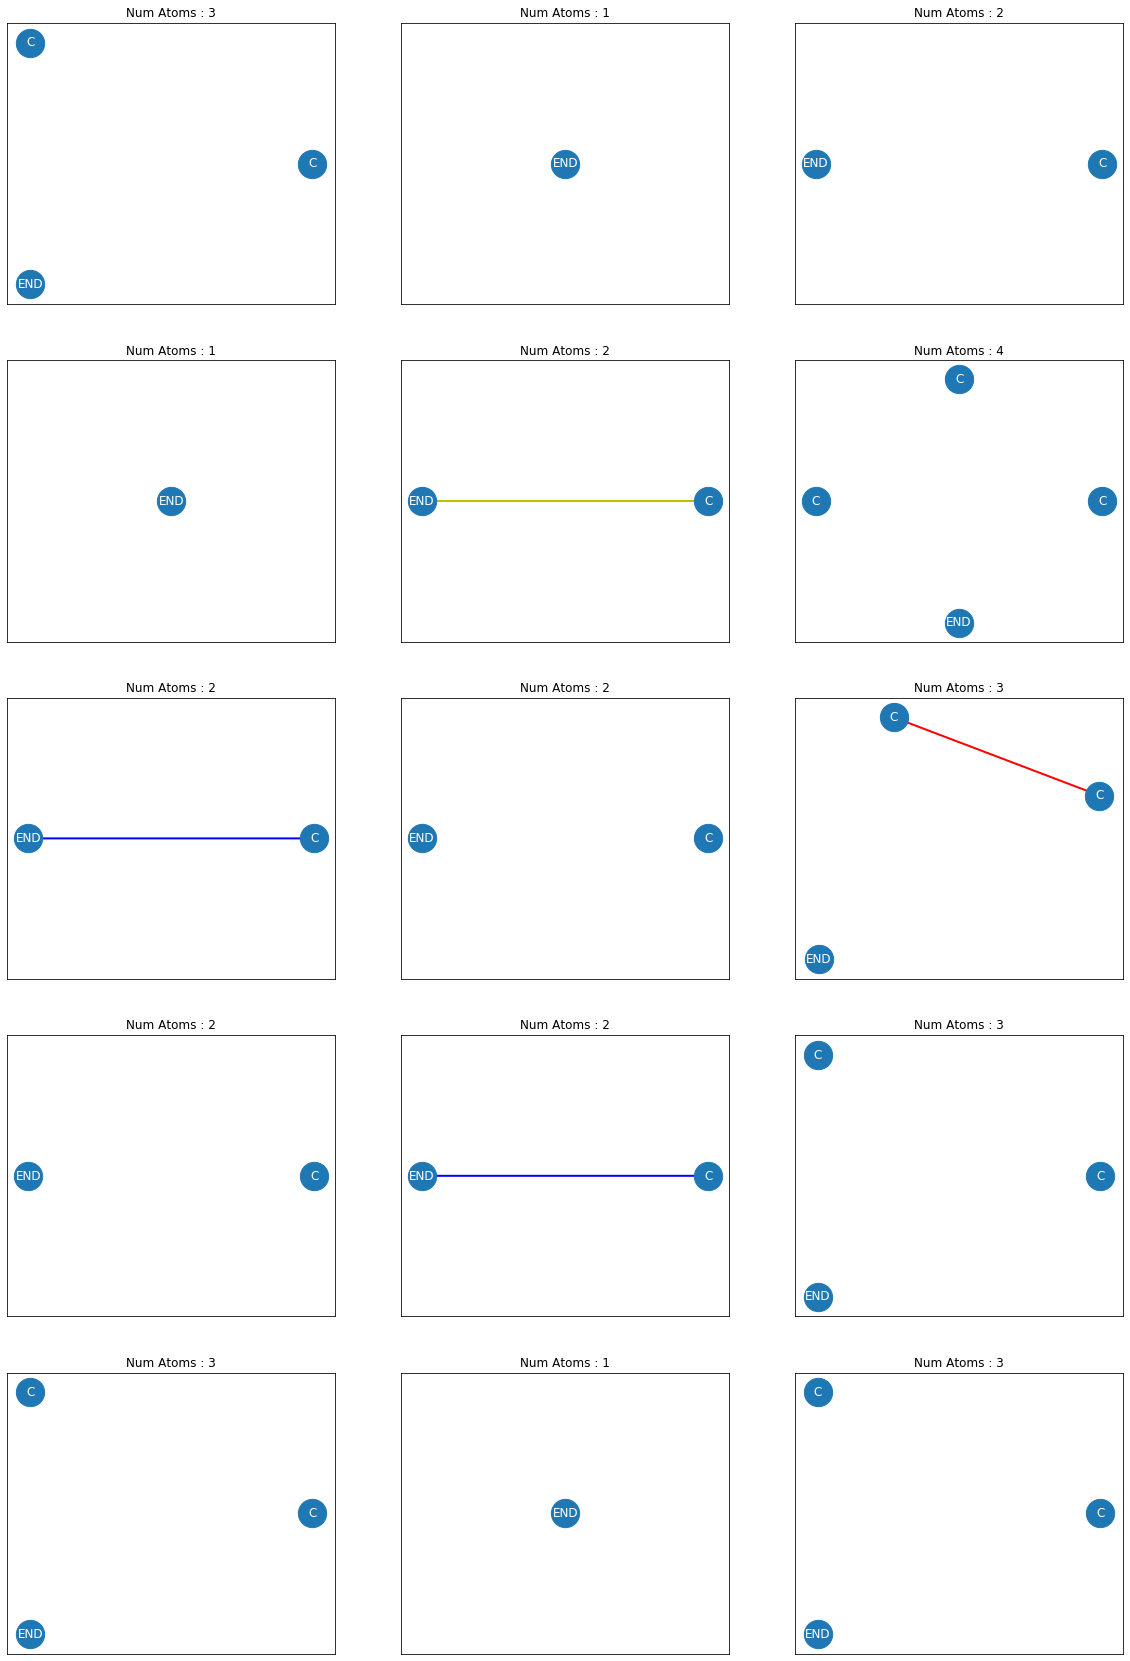

In [134]:
ncol = 3
num_iter = 3*5
nrow = math.ceil(num_iter/ncol)
plt.figure(figsize=(20, 6*num_iter//3))
for i in range(num_iter):
    plt.subplot(nrow, ncol, i+1)
    run()
plt.show()